In [1]:
# Ensure that the root directory is in Python's path. This is to make importing
# custom library easier.
from pathlib import Path
import sys
root = Path('.').absolute().parent.parent
if str(root) not in sys.path:
    sys.path.append(str(root))

# built-in packages
from collections import defaultdict
import json
from typing import List, Dict, Tuple, Callable
import dill

# external packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# matplotlib param
# https://stackoverflow.com/a/55188780/9723036
# SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
TEXT_BOTTOM = 0.9

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Part 1

## Shared class and functions

In [42]:
# DEFAULTS
RANDOM_STATE = 42

class N_ARM_BANDIT(object):
    """A class to represent an n-armed bandit task"""

    def __init__(
        self,
        n: int,
        epsilon: float,
        random_state: int = RANDOM_STATE,
    ):
        """Initialize the n-armed bandit task.
        
        :param n: The number of arms in the bandit, i.e., the number of actions
            allowed in the task.
        :param epsilon: Probability that an action is not greedy.
        :param random_state: Seed for the random state. Default to the value
            stored in RANDOM_STATE.
        """
        # random number generator
        self.rng = np.random.default_rng(random_state)
        self.n = n
        self.epsilon = epsilon
        # estimated reward for each action
        self.Qas = np.array([0.0] * n)
        # number of times each action has been taken
        self.Nas = [0] * n
        # true reward for each action
        self.qas = [self.rng.normal() for _ in range(n)]
        # the optimal action
        self.optimal_act = np.argmax(self.qas)
    
    def reward(self, act: int) -> float:
        """Compute the current reward for a given action.

        :param act: The index of the action selected.
        :return: A reward value produced upon taking the action. Based on
            the rule of the n-armed bandit, the reward is a random variable from
            a Gaussian distribution defined by the true value of the action with
            standard deviation being 1.
        """
        return self.rng.normal(self.qas[act], 1)
    
    def pick_action(self) -> int:
        """Pick an action to execute.

        With epsilon probability, the picking is purely random (exploration).
        With the remaining probablity, the picking is always greedy
        (exploitation).
        
        If multiple actions have the same max reward estimate, the tie-breaker
        is by random selection.

        :return: The index of the action picked.
        """
        if self.rng.random() < self.epsilon:  # random exploration
            return self.rng.integers(0, self.n)
        # greedy with random tiebreaks
        pot_act = np.where(self.Qas == np.max(self.Qas))[0]
        return self.rng.choice(pot_act)
    
    def step(self):
        """Perform a step, i.e., take an action, in the n-armed bandit task.

        In a step, we first pick the action to take, find out the reward
        associated with the action, and update the estimated action value for
        the selected action.

        :return: A numpy array containing two elements: the current step's
            reward and whether the action picked is the optimal action.
        """
        act = self.pick_action()
        R = self.reward(act)
        self.Nas[act] += 1
        self.Qas[act] += 1 / self.Nas[act] * (R - self.Qas[act])
        return np.array([R, act == self.optimal_act])


def n_armed_bandit_test_bed(
    n: int,
    epsilons: List[float],
    num_tasks: int = 2000,
    num_steps: int = 1000,
    random_state: int = RANDOM_STATE,
) -> List[Dict]:
    """Run the test bed for the n-armed bandit experiment.

    The logic of the test bed is as follows: Run `num_steps` of steps. In each
    step, take an action in all `num_tasks` of tasks (bandits). Aggregate the
    mean rewards and percentage of chance that the optimal action has been
    selected in the current step across all tasks. Record the above-mentioned
    two aggregates. 

    Once all steps have been taken, all bandits and the result (the aggregated
    mean rewards and optimal action percentage )are saved as pickle files. Also,
    the result is returned.

    :param n: The number of arms in the bandit task.
    :param epsilons: All the epsilon values to be examined.
    :param num_tasks: Total number of tasks (bandits).
    :param num_steps: Total number of steps.
    :param random_state: Seed for the random state. Default to the value stored 
            in RANDOM_STATE.
    :reutrn: A list of dict. Each dict corresponds to an epsilon value. In each
        dict, there are three keys: "ave_reward" for a list of average rewards,
        one per step; "opt_act" for a list of percentage that optimal action has
        been selected for each step; and "epsilon" for the epsilon value.
    """
    rng = np.random.default_rng(random_state)
    # Create `num_tasks` random tasks for each epsilon
    epsilon_tasks = [
        [N_ARM_BANDIT(n, e, rng.integers(0, 1000000)) for _ in range(num_tasks)] for e in epsilons
    ]
    res = [{'ave_reward': [], 'opt_act': [], 'epsilon': e} for e in epsilons]
    for _ in range(num_steps):
        # all the tasks under a specific epsilon
        for i, tasks in enumerate(epsilon_tasks):
            # perform action over all tasks
            R_optimal_act = np.array([task.step() for task in tasks])
            res[i]['ave_reward'].append(np.mean(R_optimal_act[:,0]))
            res[i]['opt_act'].append(np.mean(R_optimal_act[:,1]))
    
    with open('n_armed_bandit_test_bed_details.pickle', 'wb') as f_obj:
        dill.dump(epsilon_tasks, f_obj)
    with open('n_armed_bandit_test_bed_result.pickle', 'wb') as f_obj:
        dill.dump(res, f_obj)
    return res


def plot(
    test_bed_res: List[Dict],
    num_steps: int = 1000,
    filename: str = '',
) -> None:
    """Plot the step vs. average rewards, and step vs. optimal action %.

    :param test_bed_res: The result of the test bed. For details, see the
        return value explanation in the function `n_armed_bandit_test_bed`.
    :param num_steps: Total number of steps.
    :param filename: Name of the file where the plot is to be saved. Default
        to empty string, i.e., do not save the plot as a file.
    """
    steps = np.arange(num_steps)
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    for res in test_bed_res:
        axes[0].plot(
            steps,
            res['ave_reward'],
            label=f'$\epsilon={{{res["epsilon"]}}}$',
        )
        axes[1].plot(
            steps,
            np.array(res['opt_act']) * 100,
            label=f'$\epsilon={{{res["epsilon"]}}}$',
        )
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Average Rewards')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('% Optimal Action')

    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


## Run The N-armed Bandit Test Bed

Note that in this test bed, the number of steps have been extended to 10,000. With such extension, it is clear that the $\epsilon=0.01$ method catches up to $\epsilon=0.1$ method in the end and becomes the best performing method.

This confirms the statement on p30 of the textbook, which states that the $\epsilon=0.01$ method outperforms the $\epsilon=0.1$ method eventually.

In [12]:
# NOTE this cell takes A LONG TIME to run. Do not run often
# Param configuration
num_arms = 10
num_tasks = 1000
num_steps = 5000
epsilons = [0, 0.001, 0.01, 0.1, 0.3, 0.6, 1]

res = n_armed_bandit_test_bed(
    num_arms,
    epsilons,
    num_tasks=num_tasks,
    num_steps=num_steps,
)

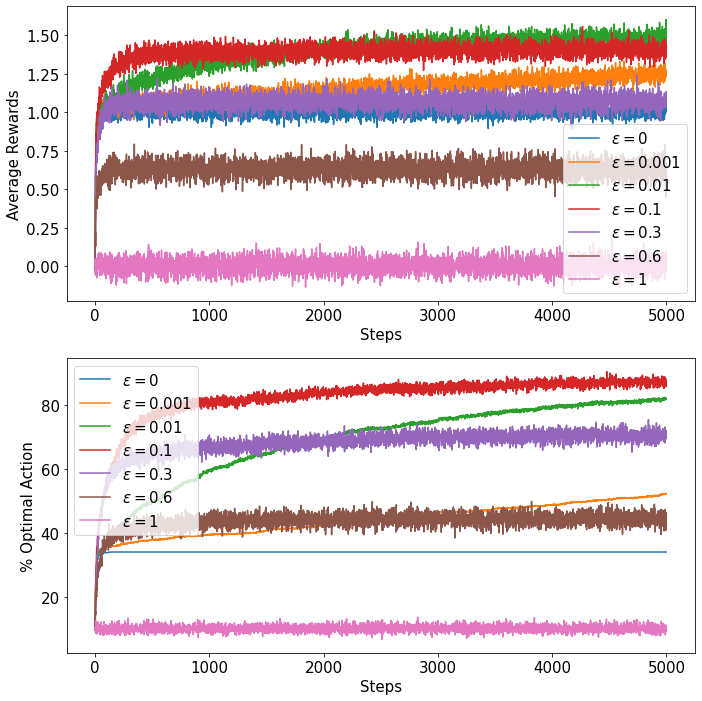

In [43]:
plot(
    res,
    num_steps=num_steps,
    filename='performance_comparison_epsilon.pdf'
)

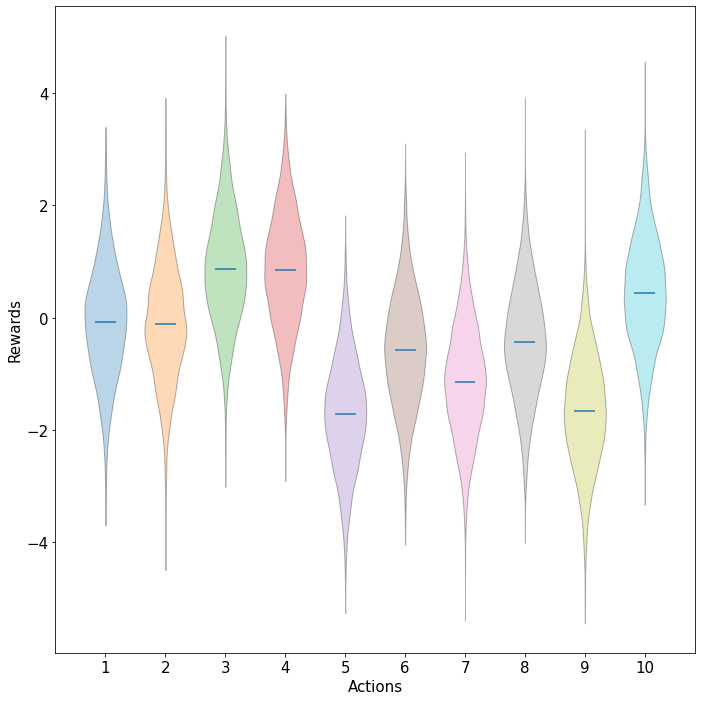

In [41]:
# Reward distribution of a sample 10-armed bandit
with open('n_armed_bandit_test_bed_details.pickle', 'rb') as f_obj:
    bandits = dill.load(f_obj)

rng = np.random.default_rng(RANDOM_STATE)
rewards_dist = np.array([rng.normal(u, 1, num_steps) for u in bandits[0][0].qas]).T

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
vp = ax.violinplot(rewards_dist, showmeans=True, showextrema=False, widths=0.7)
for i, v in enumerate(vp['bodies']):
    v.set_facecolor(f'C{i}')
    v.set_edgecolor('black')
ax.set_xticks(np.arange(1, num_arms + 1))
ax.set_xlabel('Actions')
ax.set_ylabel('Rewards')
plt.tight_layout()
plt.savefig('reward_distribution.pdf')

# Part 2

## Shared class and functions

In [59]:
# CONSTANTS
RANDOM_STATE = 42

class AD_BANDIT(object):
    """A class to represent an advertisement bandit"""

    def __init__(
        self,
        r_dist,
        epsilon: float,
        random_state: int = RANDOM_STATE,
    ):
        """Initialize the ad bandit.
        
        :param r_dist: A numpy array of array recording the reward
            distribution for all ads and over all steps.
        :param epsilon: Probability that an action is not greedy.
        :param random_state: Seed for the random state. Default to the value
            stored in RANDOM_STATE.
        """
        # random number generator
        self.rng = np.random.default_rng(random_state)
        self.r_dist = r_dist
        self.epsilon = epsilon
        # estimated reward for each action
        self.Qas = np.array([0.0] * self.r_dist.shape[1])
        # number of times each action has been taken
        self.Nas = [0] * self.r_dist.shape[1]
    
    def reward(self, act: int, step: int) -> float:
        """Find the reward for a given action at the given step.

        :param act: The index of the action selected.
        :param step: The current step.
        :return: A reward obtained from the reward distribution
            corresponding to `step` row and `act` column.
        """
        return self.r_dist[step, act]
    
    def pick_action(self) -> int:
        """Pick an action to execute.

        With epsilon probability, the picking is purely random (exploration).
        With the remaining probablity, the picking is always greedy
        (exploitation). If multiple actions have the same max reward estimate,
        the tie-breaker is by random selection.

        :return: The index of the action picked.
        """
        if self.rng.random() < self.epsilon:  # random exploration
            return self.rng.integers(0, self.r_dist.shape[1])
        # greedy with random tiebreaks
        pot_act = np.where(self.Qas == np.max(self.Qas))[0]
        return self.rng.choice(pot_act)
    
    def step(self, step) -> float:
        """Perform a step, i.e., take an action, in an ad bandit.

        In a step, we first pick the action to take, then find out the reward
        associated with the action, and update the estimated action value for
        the selected action.

        :param step: The current step.
        :return: The reward of the current step.
        """
        act = self.pick_action()
        R = self.reward(act, step)
        self.Nas[act] += 1
        self.Qas[act] += 1 / self.Nas[act] * (R - self.Qas[act])
        return R


def compute_ad_reward(
    r_dist,
    epsilons: List[float],
    num_repeats: int = 2000,
    random_state: int = RANDOM_STATE,
) -> List[Dict]:
    """Compute the average reward and acumulative it after each step.

    We run `num_repeats` number of bandits (i.e. the ad bandit) per step
    per epsilon to obtain the average reward attainable under different
    method. We also accumulate the rewards after each step to obtain the
    max possible rewards achieveable under different method.

    :param r_dist: A numpy array of array representing the reward
        distribution.
    :param epsilons: A list of probability that an action is not greedy.
        Each epsilon value represent one epsilon-greedy method.
    :param num_repeats: The number of repetitions the ad bandit is run in
        each step.
    :param random_state: Seed for the random state. Default to the value
            stored in RANDOM_STATE.
    """
    rng = np.random.default_rng(random_state)
    # Create `num_repeats` random tasks for each epsilon
    epsilon_bandits = [
        [AD_BANDIT(r_dist, e, rng.integers(0, 1000000)) for _ in range(num_repeats)] for e in epsilons
    ]
    res = [
        {
            'total_reward': [0.0],
            'epsilon': e,
            'reward_per_ad': None,
            'picks_per_ad': None,
        } for e in epsilons
    ]
    for step in range(r_dist.shape[0]):
        # all the bandits under a specific epsilon
        for i, bandits in enumerate(epsilon_bandits):
            # perform action over all bandits
            Rs = np.array([bandit.step(step) for bandit in bandits])
            # Accumulate the reward (averaged over `num_repeats` number of
            # bandits) of each step, 
            res[i]['total_reward'].append(
                np.mean(Rs) + res[i]['total_reward'][-1],
            )
    # Compute average reward and picks per add
    for i, bandits in enumerate(epsilon_bandits):
        all_ad_rewards = np.array([bandit.Qas for bandit in bandits])
        res[i]['reward_per_ad'] = np.mean(all_ad_rewards, axis=0)
        all_ad_picks = np.array([bandit.Nas for bandit in bandits])
        res[i]['picks_per_ad'] = np.mean(all_ad_picks, axis=0)
    return res


def plot_total_rewards(
    ad_reward_res: List[Dict],
    r_dist,
    epsilons: List[float],
    filename: str = '',
) -> None:
    """Plot the step vs. total rewards curve and final reward bar plot.

    :param ad_reward_res: The average reward of running the ads under different
        epsilon values.
    :param r_dist: A numpy array of array representing the reward distribution.
    :param filename: Name of the file where the plot is to be saved. Default
        to empty string, i.e., do not save the plot as a file.
    """
    steps = np.arange(r_dist.shape[0] + 1)    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    # Reward trend plot
    for res in ad_reward_res:
        ax1.plot(
            steps,
            res['total_reward'],
            label=f'$\epsilon={{{res["epsilon"]}}}$',
        )
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Total Rewards')

    # Final reward per epsilon plot
    bar_x = np.arange(1, len(epsilons) + 1)
    bar_y = np.array([res['total_reward'][-1] for res in ad_reward_res])
    rects = ax2.bar(bar_x, bar_y, 0.5)
    for rect in rects:
        height = rect.get_height()
        ax2.annotate(  # add the value of each bar on top of the bar
            '{0:.2f}'.format(height),
            xy=(rect.get_x(), height + 15),
        )
    ax2.set_xticks(bar_x)
    ax2.set_xticklabels([str(e) for e in epsilons])
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Final Rewards')

    ax1.legend()
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


def plot_ad_data(
    ad_reward_res: List[Dict],
    num_ads: int,
    epsilons: List[float],
    filename: str = '',
) -> None:
    """Plot the average reward and picks per ad over different epsilons.

    The plot is a bar-plot, with x-axis being the label for each ad and
    y-axis the average reward or average number of picks. Different epsilon
    value is depicted with a unique color.

    :param ad_reward_res: The average reward of running the ads under different
        epsilon values. It contains the average reward per ad.
    :param num_ads: Number of ads.
    :param filename: Name of the file where the plot is to be saved. Default
        to empty string, i.e., do not save the plot as a file.
    """
    num_bars = len(epsilons)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    # coordinates where the ad label is shown
    x = np.arange(0, num_bars * num_ads, num_bars)
    width = 0.8  # width of each bar
    # The amount of shifts each bar requires, one per epsilon valu
    deltas = np.arange(-(num_bars - 1) / 2, (num_bars - 1) / 2 + 1, 1)
    # Plot one bar per ad, whose coordinate is computed dynamically
    for res, delta in zip(ad_reward_res, deltas):
        ax1.bar(
            x + delta * width,
            res['reward_per_ad'],
            width,
            label=res['epsilon'],
        )
        ax2.bar(
            x + delta * width,
            res['picks_per_ad'],
            width,
            label=res['epsilon'],
        )

    x_tick_label = [str(n) for n in range(1, num_ads + 1)]
    ax1.set_xlabel('Ads')
    ax1.set_ylabel('Ave Reward')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_tick_label)
    ax1.legend()

    ax2.set_xlabel('Ads')
    ax2.set_ylabel('Ave Picks')
    ax2.set_xticks(x)
    ax2.set_xticklabels(x_tick_label)
    ax2.legend()

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


## Compute the rewards

Parameters used:

* $\epsilon$: Seven $\epsilon$ values are used $[0, 0.001, 0.01, 0.1, 0.3, 0.6, 1]$
* Number of ad bandits per step: 100

In [46]:
r_dist = pd.read_csv('Ads_Optimisation.csv').to_numpy()
epsilons = [0, 0.001, 0.01, 0.1, 0.3, 0.6, 1]
rewards = compute_ad_reward(r_dist, epsilons, num_repeats=100)

## Reward trend and final reward per $\epsilon$

The plots below show the reward trend and the final reward per $\epsilon$ value.

The top plot shows the trend of the accumulated rewards over steps for each $\epsilon$. It is obvious that the ranking of the $\epsilon$ values is determined pretty early in the steps, and mostly does not change over the entire 10,000 steps. $\epsilon = 0.1$ is the clear winner, while $\epsilon = 1$ performs the worst.

The bottom plot provides a detailed view of the final rewards after 10,000 steps for each $\epsilon$ value, averaged over the 100 ad bandits. We observe that as the $\epsilon$ value increases, the reward first increases until a peak reached when $\epsilon = 0.1$. Afterwards, the reward decreases. This plot clearly shows that neither pure greedy ($\epsilon = 0$) nor pure random ($\epsilon = 1$) is the best strategy for running the ads. The best performing method is when exploration happens around 10% of the time ($\epsilon=0.1$).

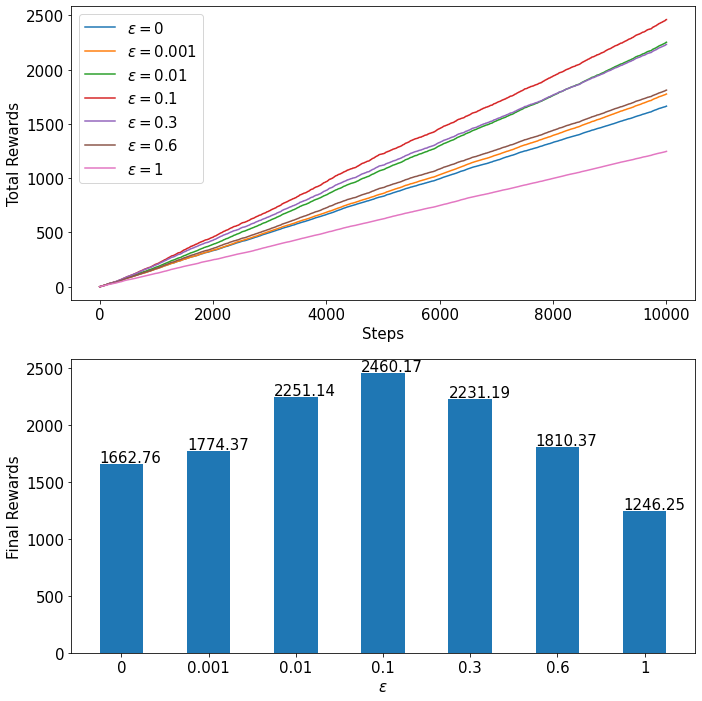

In [60]:
plot_total_rewards(
    rewards,
    r_dist,
    epsilons,
    filename='ads_data_total_rewards.pdf'
)

## Average return and number of picks per ad

The plots below show the average return and number of picks for each ad under different $\epsilon$ values.

The top plot demonstrate the average return of each ad. It is clear that as the probability of exploration increases, the average return computed converges more towards the true reward of each ad. All the methods with $\epsilon \ge 0.1$ have good convergence of each ad's true reward, yet the rest methods with smaller $\epsilon$ values have poor convergence. Among all the ads, Ad 5 clearly has the best return.

The bottom plot illustrates the average number of picks through out the 10,000 steps for each ad. The best method is clearly when $\epsilon = 0.1$, as it almost exclusively picks Ad 5. The other methods don't pick Ad 5 as often, hence their inferior performance compared to $\epsilon = 0.1$. When $\epsilon = 1$, i.e. pure exloration, we can see that each ad gets picked about the same number of times.

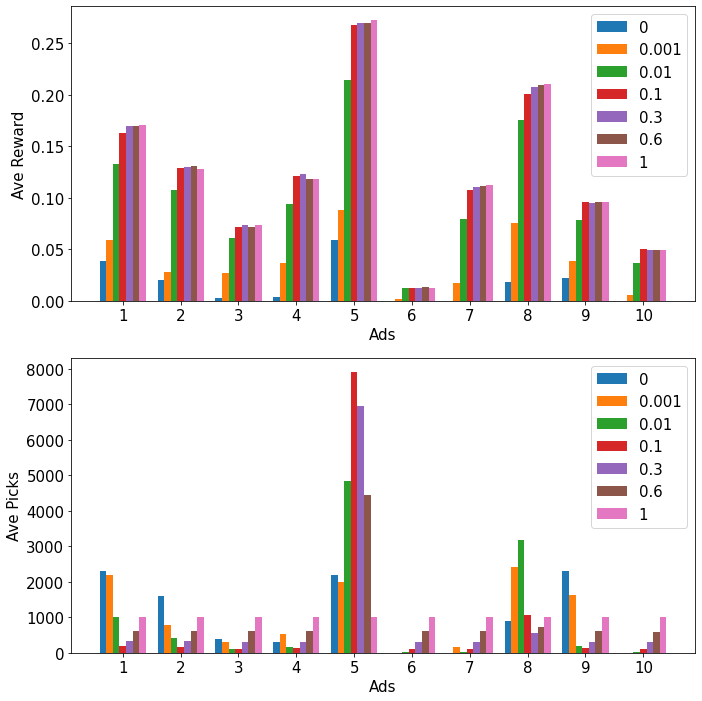

In [54]:
plot_ad_data(
    rewards,
    r_dist.shape[1],
    epsilons,
    filename='ads_data_ave_reward_picks.pdf'
)